This code is used to reformat the data quoted from various papers, 
then compare the pulsar positions from timing and VLBI astrometry.

In [1]:
from functools import reduce

import numpy as np
import seaborn as sns
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, join, vstack
from astropy.time import Time
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import NullLocator
from numpy import concatenate, cos, pi, sin, sqrt
from psrcrf_tools import *
from scipy.optimize import curve_fit
from statsmodels.iolib.table import SimpleTable

/Users/Neo/Scisoft/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1 Data preparation

## 1.1 Load the database

Read the timing solution data.

In [2]:
timing_table = Table.read("../data/timing_vlbi.fits")
timing_table.sort("psr_name")

In [3]:
msp_list = [
    "J1022+1001", "J2010-1323", "J2145-0750", "J2317+1439", "J1012+5307", "J1537+1155"
]

In [4]:
temp_table = Table([])

for msp_name in msp_list:
    mask = timing_table["psr_name"] == msp_name
    temp_table = vstack((temp_table, timing_table[mask]))

timing_table = Table(temp_table, masked=False)

Add unit information

In [5]:
timing_table["ra"].unit = u.deg
timing_table["dec"].unit = u.deg
timing_table["pmra"].unit = u.mas / u.yr
timing_table["pmdec"].unit = u.mas / u.yr
timing_table["plx"].unit = u.mas
timing_table["ra_err"].unit = u.mas
timing_table["dec_err"].unit = u.mas
timing_table["pmra_err"].unit = u.mas / u.yr
timing_table["pmdec_err"].unit = u.mas / u.yr
timing_table["plx_err"].unit = u.mas

Load the cross-match table.

In [6]:
vlbi_table = Table.read("../data/psrpi.dat", format="ascii")

Add unit information

In [7]:
vlbi_table["ra"].unit = u.deg
vlbi_table["dec"].unit = u.deg
vlbi_table["pmra"].unit = u.mas / u.yr
vlbi_table["pmdec"].unit = u.mas / u.yr
vlbi_table["plx"].unit = u.mas
vlbi_table["ra_err"].unit = u.mas
vlbi_table["dec_err"].unit = u.mas
vlbi_table["pmra_err"].unit = u.mas / u.yr
vlbi_table["pmdec_err"].unit = u.mas / u.yr
vlbi_table["plx_err"].unit = u.mas

Supplement the timing table with the VLBI astrometrical information.

In [8]:
vlbi_timing = join(timing_table,
                   vlbi_table,
                   keys="psr_name",
                   join_type="left",
                   table_names=["t", "v"])

vlbi_timing.rename_column("pos_epoch_t", "pos_epoch")

count_psr_nb(vlbi_timing)

There are 6 pulsars with 46 measurements.


## 1.2 Comparison of pulsar positions from timing and VLBI

Propagate the VLBI position from its epoch to the timing positonal epoch and compute the positional offset,
in the sense of timing minus VLBI.

In [9]:
# Epoch difference in Julian year
dt_y = (vlbi_timing["pos_epoch"].value -
        vlbi_timing["pos_epoch_v"]) / 365.25 * u.yr

# Cos(decl.) factor for the difference in R.A.
dec_fac = cos(np.deg2rad(vlbi_timing["dec_v"].value))

dra = (vlbi_timing["ra_t"] - vlbi_timing["ra_v"]) * \
    dec_fac - dt_y * vlbi_timing["pmra_v"]

ddec = vlbi_timing["dec_t"] - vlbi_timing[
    "dec_v"] - dt_y * vlbi_timing["pmdec_v"]

dra = dra.to(u.mas)
ddec = ddec.to(u.mas)

vlbi_timing.add_columns([dra, ddec], names=["dra", "ddec"])

In [10]:
vlbi_timing["ra_err_t"] = vlbi_timing["ra_err_t"] * dec_fac

dra_err = np.sqrt(vlbi_timing["ra_err_v"]**2 + vlbi_timing["ra_err_t"]**2 +
                  (dt_y * vlbi_timing["pmra_err_v"]).value**2)

ddec_err = np.sqrt(vlbi_timing["dec_err_v"]**2 + vlbi_timing["dec_err_t"]**2 +
                   (dt_y * vlbi_timing["pmdec_err_v"]).value**2)

vlbi_timing.add_columns([dra_err, ddec_err], names=["dra_err", "ddec_err"])

## 1.3 Plot sky distribution of the pulsar sample

In [11]:
mask = vlbi_timing["eph"] == "DE200"
vlbi_timing200 = vlbi_timing[mask]

mask = vlbi_timing["eph"] == "DE405"
vlbi_timing405 = vlbi_timing[mask]

mask = vlbi_timing["eph"] == "DE421"
vlbi_timing421 = vlbi_timing[mask]

mask = vlbi_timing["eph"] == "DE430"
vlbi_timing430 = vlbi_timing[mask]

mask = vlbi_timing["eph"] == "DE436"
vlbi_timing436 = vlbi_timing[mask]

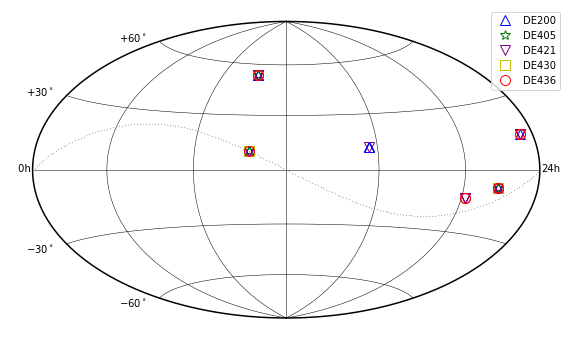

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")

# Uniform sampling in longtitude and latitude
lon_arr = np.arange(0, 361, 5)
lat_arr = np.arange(-90, 91, 1)

# Plot a ellipse border.
lon_bords = np.array([0, 360])

# A loop to plot 7 grid.
for lon_bord in lon_bords:
    lat = lat_arr
    lon = np.ones_like(lat) * lon_bord
    X, Y = hammer_projection(lon, lat)
    ax.plot(X, Y, "k", linewidth=1.5)

# Grid plot.
# longtitude_grid_plot()
# 6 nodes in the longtitude from 0 to 360 deg.
lon_nodes = np.arange(60, 360, 60)

# A loop to plot 7 grid.
for lon_node in lon_nodes:
    lat = lat_arr
    lon = np.ones_like(lat) * lon_node
    X, Y = hammer_projection(lon, lat)
    ax.plot(X, Y, "k", linewidth=0.5)

# latitude_grid_plot()
# 5 nodes in the latitude from -60 to +60 deg.
lat_nodes = np.arange(-60, 61, 30)

# A loop to plot 7 grid.
for lat_node in lat_nodes:
    lon = lon_arr
    lat = np.ones_like(lon) * lat_node
    X, Y = hammer_projection(lon, lat)
    ax.plot(X, Y, "k", linewidth=0.5)

# Grid tickers.
# For fundamental plane.
lon0 = np.array([0, 360])
lat0 = np.array([0, 0])
X0, Y0 = hammer_projection(lon0, lat0)

ax.text(X0[0] - 0.2, Y0[0] - 0.025, " 0h")
ax.text(X0[1] + 0.02, Y0[1] - 0.025, "24h")

# For latitude grid
lon = np.array([0, 0])
lat = np.array([30, 60])
X, Y = hammer_projection(lon, lat)

for i in range(lat.size):
    ax.text(X[i] - 0.45, Y[i] - 0.0, "$+%d^\circ$" % lat[i])
    ax.text(X[i] - 0.45, -Y[i] - 0.1, "$-%d^\circ$" % lat[i])

# Plot the source.
shift = 0.025
# DE200
X, Y = hammer_projection(vlbi_timing200["ra_v"], vlbi_timing200["dec_v"])
ax.plot(X, Y, "^", mfc="none", mec="b", ms=10, label="DE200")

# DE405
X, Y = hammer_projection(vlbi_timing405["ra_v"], vlbi_timing405["dec_v"])
ax.plot(X, Y, "*", mfc="none", mec="g", ms=10, label="DE405")

# DE421
X, Y = hammer_projection(vlbi_timing421["ra_v"], vlbi_timing421["dec_v"])
ax.plot(X, Y, "v", mfc="none", mec="purple", ms=10, label="DE421")

# DE430
X, Y = hammer_projection(vlbi_timing430["ra_v"], vlbi_timing430["dec_v"])
ax.plot(X, Y, "s", mfc="none", mec="y", ms=10, label="DE430")

# DE436
X, Y = hammer_projection(vlbi_timing436["ra_v"], vlbi_timing436["dec_v"])
ax.plot(X, Y, "o", mfc="none", mec="r", ms=10, label="DE436")

lon_arr = np.arange(0, 361, 2)
lat_arr = np.zeros_like(lon_arr)
ecl_plane = SkyCoord(lon_arr, lat_arr, unit="deg",
                     frame="barycentricmeanecliptic")
ecl_plane_equ = ecl_plane.icrs
ecl_ra = ecl_plane_equ.ra.value
ecl_dec = ecl_plane_equ.dec.value
X, Y = hammer_projection(ecl_ra, ecl_dec)
ax.plot(X, Y, ".", ms=0.5, color="grey")

ax.legend()

## 1.4 Compute statistics of positional formal uncertainties

In [13]:
# For comparison of positional uncertainty
pos_err_tab = np.zeros((5, 6))

pos_err_tab[0, :] = calc_med_pos_err(vlbi_timing200, ref="v")
pos_err_tab[1, :] = calc_med_pos_err(vlbi_timing405, ref="v")
pos_err_tab[2, :] = calc_med_pos_err(vlbi_timing421, ref="v")
pos_err_tab[3, :] = calc_med_pos_err(vlbi_timing430, ref="v")
pos_err_tab[4, :] = calc_med_pos_err(vlbi_timing436, ref="v")

/Users/Neo/Scisoft/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


## 1.5 Remove pulsars near ecliptic plane

In [14]:
mask = (
    (vlbi_timing["psr_name"] != "J0614+2229")
    & (vlbi_timing["psr_name"] != "J0629+2415")
    #     & (vlbi_timing["psr_name"] != "J0826+2637")
    & (vlbi_timing["psr_name"] != "J1022+1001")
    & (vlbi_timing["psr_name"] != "J1257-1027")
    #     & (vlbi_timing["psr_name"] != "J1650-1654")
    & (vlbi_timing["psr_name"] != "J1703-1846")
    #     & (vlbi_timing["psr_name"] != "J2010-1323")
    #     & (vlbi_timing["psr_name"] != "J2145-0750")
    #     & (vlbi_timing["psr_name"] != "J2248-0101")
    & (vlbi_timing["psr_name"] != "J2346-0609")
)

vlbi_timing = Table(vlbi_timing[mask], masked=False)

# 2. Comparison of pulsar positions from timing and VLBI

##  2.1 DE200 vs VLBI

In [15]:
mask = vlbi_timing["eph"] == "DE200"
vlbi_timing200 = vlbi_timing[mask]

nb_psr_200 = len(vlbi_timing200.group_by("psr_name").groups)
nb_obs_200 = len(vlbi_timing200)

count_psr_nb(vlbi_timing200)

There are 4 pulsars with 10 measurements.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


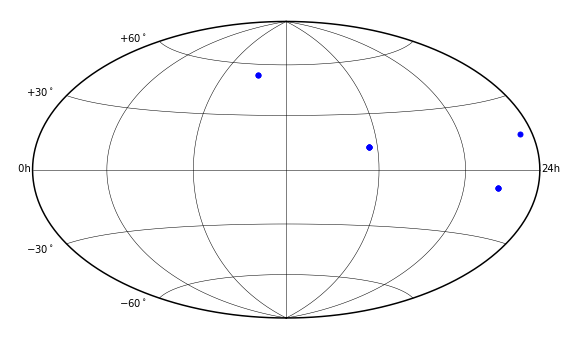

In [16]:
sou_dist_plot(vlbi_timing200["ra_v"], vlbi_timing200["dec_v"])

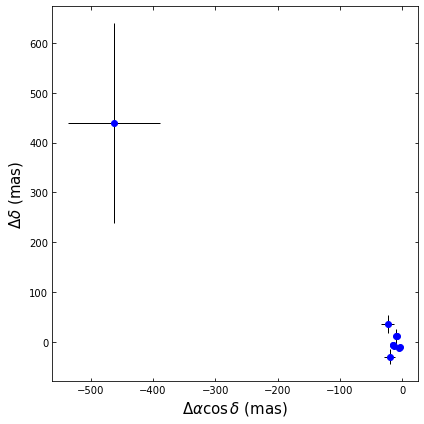

In [17]:
simple_plot(vlbi_timing200)

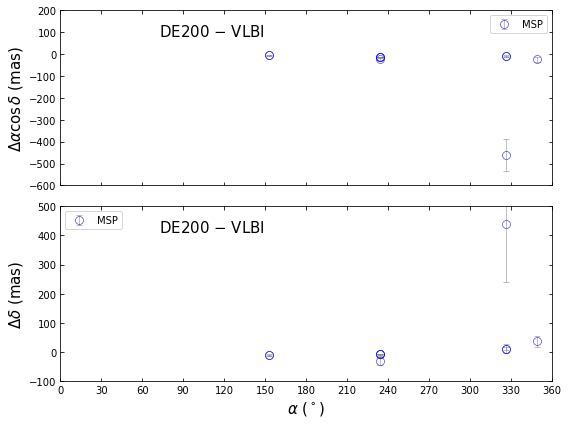

In [18]:
pos_oft_vs_coord(
    vlbi_timing200,
    [-600, 200, -100, 500],
    vlbi_timing200["dra"],
    vlbi_timing200["ddec"],
    add_text=[0.2, 0.85, "DE200 $-$ VLBI"],
    ref="v",
    xaxis="ra",
    divided=True,
)

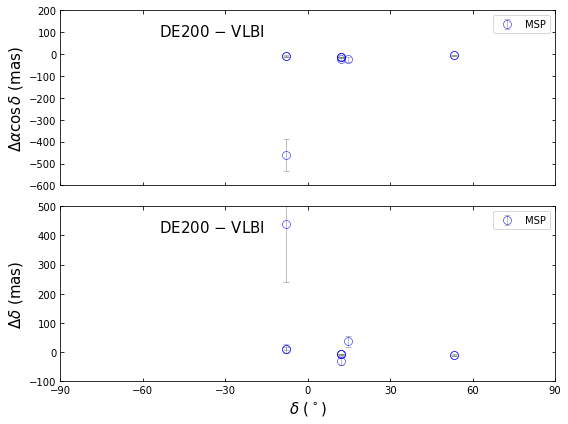

In [19]:
pos_oft_vs_coord(
    vlbi_timing200,
    [-600, 200, -100, 500],
    vlbi_timing200["dra"],
    vlbi_timing200["ddec"],
    add_text=[0.2, 0.85, "DE200 $-$ VLBI"],
    ref="v",
    xaxis="dec",
    divided=True,
)

In [20]:
pmt200, sig200, indx, apr_chi2_200, pst_chi2_200 = rot_fit_4_table(
    vlbi_timing200, ref="v")

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1  4     57.0      3.2      -0.89     -13.02     -12.21 J1537+1155    50300      0.1
 2  4     45.2      3.6      -0.79     -13.05     -12.13 J1537+1155    50261      0.1
 3  4     29.9      4.2      -0.76     -12.98     -11.90 J1537+1155    48778      0.4
 4  4     13.8      4.9      -2.25     -12.05     -11.28 J2145-0750    48979     42.2
 5  4     11.8      0.9      -2.37     -11.95     -11.06 J2145-0750    50317      0.3
 6  4      9.8      0.9       0.80     -13.44     -15.93 J1012+5307    50700      0.1
 7  4      9.4      1.3       1.34     -14.05     -15.92 J1012+5307    50914      0.3
 8  3     11.7      0.3      18.69     -32.44     -15.61 J1537+1155    50515      0.1


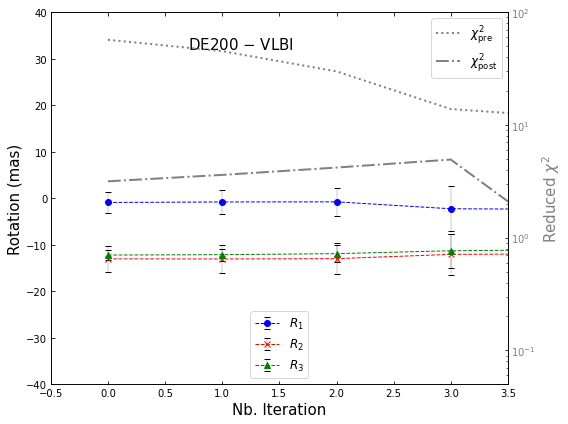

In [21]:
rot_vs_iter(
    pmt200,
    sig200,
    [-0.5, 3.5, -40, 40],
    elw=0.2,
    add_text=[0.3, 0.9, "DE200 $-$ VLBI"],
    apr_chi2=apr_chi2_200,
    pst_chi2=pst_chi2_200,
    ax_loc="lower center",
    ax1_loc="upper right",
    ax1_ylim=[0.05, 100],
)

Remove the large offset > 100 mas.

In [22]:
vlbi_timing200_1 = vlbi_timing200[vlbi_timing200["ddec"] < 300]

In [23]:
rot200, iqr200, dra_200, ddec_200, a_chi2_200, p_chi2_200 = simple_rot_fit_4_table(
    vlbi_timing200_1, ref="v")

[msg] There are 9 timing solutions for 4 pulsars
[msg] Before removing outliers, the reduced chi-squared is 51.04.
[msg] There is no outliers.
[info] NO.Obs  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  R1_err  R2_err R3_err
[info] Unit: mas
[info]  9  4     51.0      0.6      -0.90     -13.04     -12.18       0.99       1.21       0.48


In [24]:
rot200, iqr200, dra_200, ddec_200, a_chi2_200, p_chi2_200 = simple_rot_fit_4_table(
    vlbi_timing200, ref="v")

[msg] There are 10 timing solutions for 4 pulsars
[msg] Before removing outliers, the reduced chi-squared is 48.00.
[msg] There is no outliers.
[info] NO.Obs  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  R1_err  R2_err R3_err
[info] Unit: mas
[info] 10  4     48.0      3.2      -0.89     -13.02     -12.21       2.26       2.77       1.09


## 1.2 DE405 vs VLBI

In [25]:
mask = vlbi_timing["eph"] == "DE405"
vlbi_timing405 = vlbi_timing[mask]

nb_psr_405 = len(vlbi_timing405.group_by("psr_name").groups)
nb_obs_405 = len(vlbi_timing405)

count_psr_nb(vlbi_timing405)
# vlbi_timing405

There are 2 pulsars with 3 measurements.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


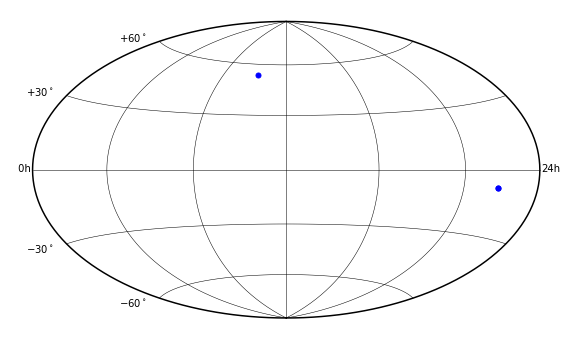

In [26]:
sou_dist_plot(vlbi_timing405["ra_v"], vlbi_timing405["dec_v"])

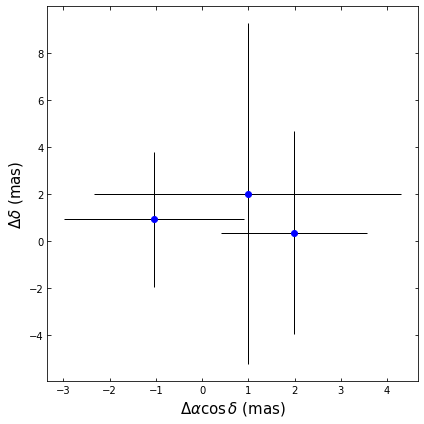

In [27]:
simple_plot(vlbi_timing405)

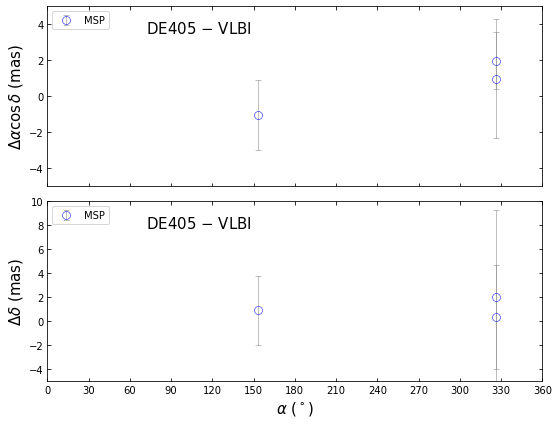

In [28]:
pos_oft_vs_coord(
    vlbi_timing405,
    [-5, 5, -5, 10],
    vlbi_timing405["dra"],
    vlbi_timing405["ddec"],
    add_text=[0.2, 0.85, "DE405 $-$ VLBI"],
    ref="v",
    xaxis="ra",
    divided=True,
)

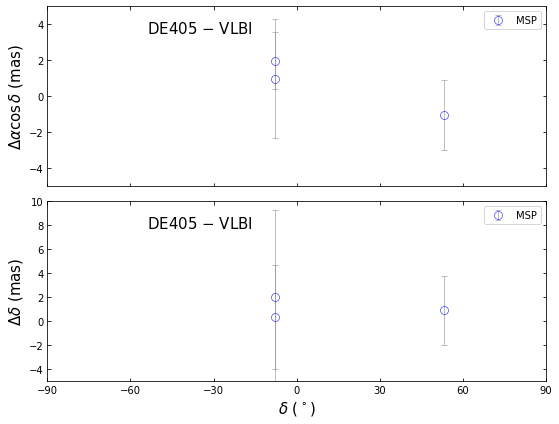

In [29]:
pos_oft_vs_coord(
    vlbi_timing405,
    [-5, 5, -5, 10],
    vlbi_timing405["dra"],
    vlbi_timing405["ddec"],
    add_text=[0.2, 0.85, "DE405 $-$ VLBI"],
    ref="v",
    xaxis="dec",
    divided=True,
)

In [30]:
# rot405, iqr405, dra_405, ddec_405, a_chi2_405, p_chi2_405 = simple_rot_fit_4_table(
#     vlbi_timing405, ref="v")

## 1.3 DE421 vs VLBI

In [31]:
mask = vlbi_timing["eph"] == "DE421"
vlbi_timing421 = vlbi_timing[mask]

nb_psr_421 = len(vlbi_timing421.group_by("psr_name").groups)
nb_obs_421 = len(vlbi_timing421)

count_psr_nb(vlbi_timing421)
# vlbi_timing421

There are 5 pulsars with 14 measurements.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


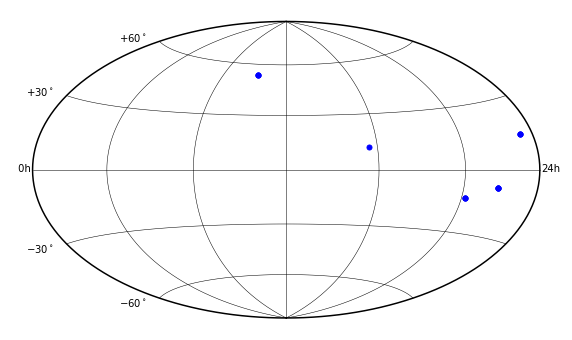

In [32]:
sou_dist_plot(vlbi_timing421["ra_v"], vlbi_timing421["dec_v"])

We have 11 pulsars in the sample from DE421 vs. VLBI comparison.

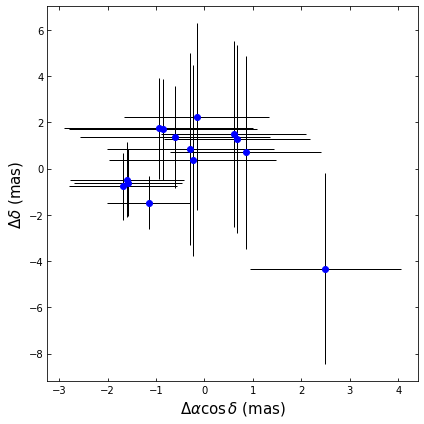

In [33]:
simple_plot(vlbi_timing421)

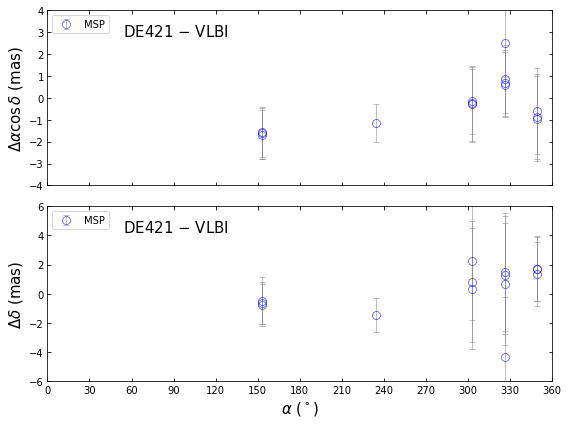

In [34]:
pos_oft_vs_coord(
    vlbi_timing421,
    [-4, 4, -6, 6],
    vlbi_timing421["dra"],
    vlbi_timing421["ddec"],
    add_text=[0.15, 0.85, "DE421 $-$ VLBI"],
    ref="v",
    xaxis="ra",
    divided=True,
)

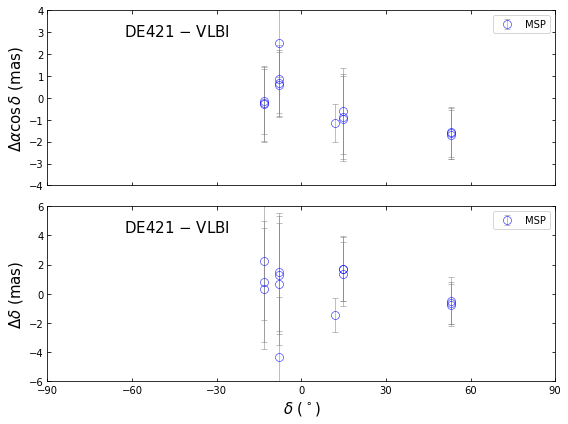

In [35]:
pos_oft_vs_coord(
    vlbi_timing421,
    [-4, 4, -6, 6],
    vlbi_timing421["dra"],
    vlbi_timing421["ddec"],
    add_text=[0.15, 0.85, "DE421 $-$ VLBI"],
    ref="v",
    xaxis="dec",
    divided=True,
)

In [36]:
pmt421, sig421, indx, apr_chi2_421, pst_chi2_421 = rot_fit_4_table(
    vlbi_timing421, ref="v")

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1  5      0.7      0.5      -0.87      -0.71      -0.36 J2145-0750    54903      5.2
 2  5      0.6      0.3      -0.88      -0.83      -0.59 J1537+1155    52077      2.3
 3  4      0.5      0.2      -1.82      -0.22      -0.10 J1012+5307    55000      0.2
 4  4      0.4      0.2      -1.65      -0.37      -0.11 J1012+5307    55000      0.3
 5  4      0.3      0.2      -1.32      -0.69      -0.12 J1012+5307    54902      0.7
 6  3      0.2      0.1       0.66      -1.82      -0.17 J2317+1439    55000      0.1
 7  3      0.2      0.1       0.37      -1.67      -0.09 J2317+1439    55000      0.1
 8  3      0.2      0.1      -0.17      -1.27       0.06 J2317+1439    54977      0.1


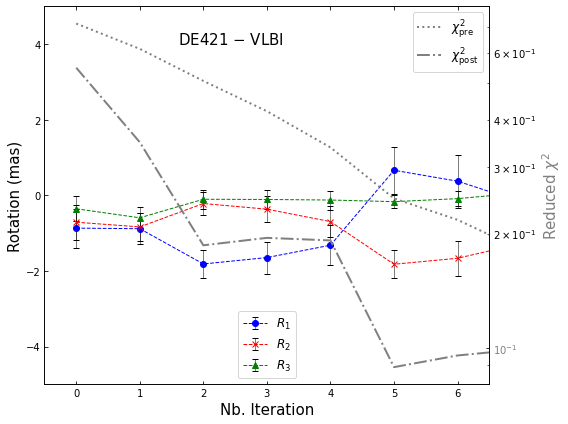

In [37]:
rot_vs_iter(
    pmt421,
    sig421,
    [-0.5, 6.5, -5, 5],
    elw=0.5,
    add_text=[0.3, 0.9, "DE421 $-$ VLBI"],
    apr_chi2=apr_chi2_421,
    pst_chi2=pst_chi2_421,
    ax_loc="lower center",
    ax1_loc="upper right",
)

In [38]:
rot421, iqr421, dra_421, ddec_421, a_chi2_421, p_chi2_421 = simple_rot_fit_4_table(
    vlbi_timing421, ref="v")

[msg] There are 14 timing solutions for 5 pulsars
[msg] Before removing outliers, the reduced chi-squared is 0.64.
[msg] There is no outliers.
[info] NO.Obs  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  R1_err  R2_err R3_err
[info] Unit: mas
[info] 14  5      0.6      0.5      -0.87      -0.71      -0.36       0.52       0.46       0.33


## 1.4 DE430 vs VLBI

In [39]:
mask = vlbi_timing["eph"] == "DE430"
vlbi_timing430 = vlbi_timing[mask]

nb_psr_430 = len(vlbi_timing430.group_by("psr_name").groups)  # =2
nb_obs_430 = len(vlbi_timing430)  # =3

count_psr_nb(vlbi_timing430)
vlbi_timing430

There are 1 pulsars with 2 measurements.


psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,pos_epoch_v,ra_v,dec_v,pmra_v,pmdec_v,plx_v,ra_err_v,dec_err_v,pmra_err_v,pmdec_err_v,plx_err_v,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,mas,mas,mas,mas
bytes10,str11,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J2145-0750,J2145-0750,57600.0,DE430,326.4602303467,-7.8384907083,0.0,0.0,0.0,11.808305658004317,33.636,0.0,0.0,0.0,lbs+20,UTMOST-II,56000.0,326.460245,-7.8384761111,-9.51,-9.1,1.6,1.486,4.0,0.04,0.09,0.03,-10.599854190719638,-12.686812538834936,11.902729998616817,33.87529969560823
J2145-0750,J2145-0750,57600.0,DE430,326.4602329166667,-7.838497222222222,-9.4,-12.8,0.0,2.944200630903625,7.0,0.3,0.8,0.0,jbs+19,UTMOST-I,56000.0,326.460245,-7.8384761111,-9.51,-9.1,1.6,1.486,4.0,0.04,0.09,0.03,-1.4344190646548802,-36.13693253825908,3.3026074944094144,8.07189156686798


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


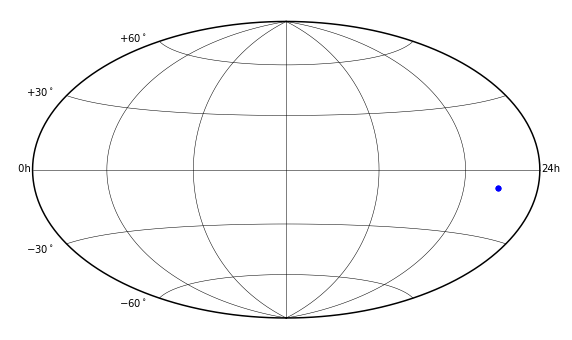

In [40]:
sou_dist_plot(vlbi_timing430["ra_v"], vlbi_timing430["dec_v"])

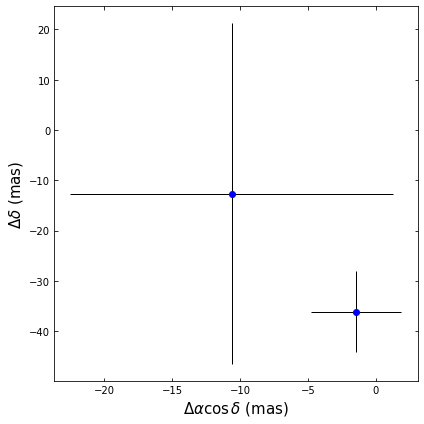

In [41]:
simple_plot(vlbi_timing430)

## 1.5 DE436 vs VLBI

In [42]:
mask = vlbi_timing["eph"] == "DE436"
vlbi_timing436 = vlbi_timing[mask]

nb_psr_436 = len(vlbi_timing436.group_by("psr_name").groups)
nb_obs_436 = len(vlbi_timing436)

count_psr_nb(vlbi_timing436)
# vlbi_timing436

There are 4 pulsars with 9 measurements.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


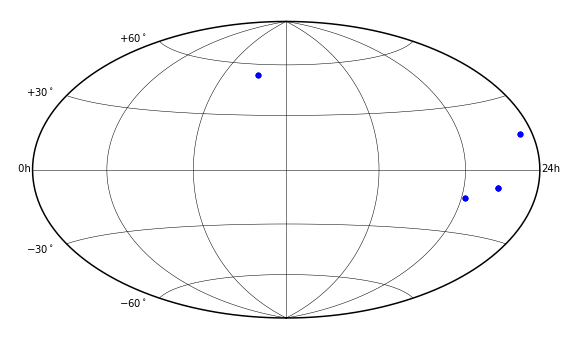

In [43]:
sou_dist_plot(vlbi_timing436["ra_v"], vlbi_timing436["dec_v"])

We have 4 pulsars in the sample from DE405 vs. Gaia comparison.

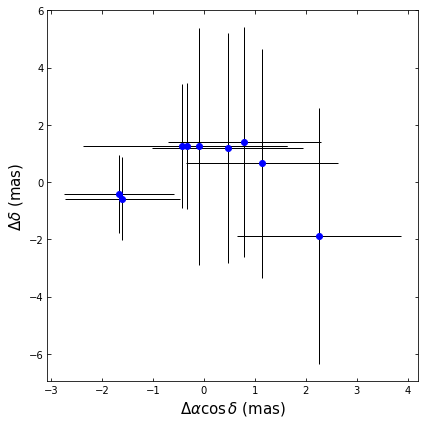

In [44]:
simple_plot(vlbi_timing436)

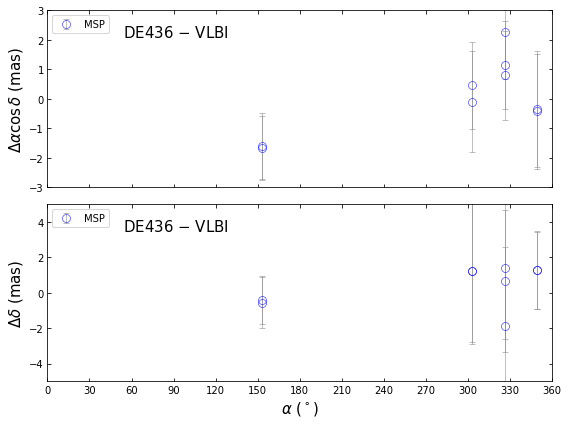

In [45]:
pos_oft_vs_coord(
    vlbi_timing436,
    [-3, 3, -5, 5],
    vlbi_timing436["dra"],
    vlbi_timing436["ddec"],
    add_text=[0.15, 0.85, "DE436 $-$ VLBI"],
    ref="v",
    xaxis="ra",
    divided=True,
)

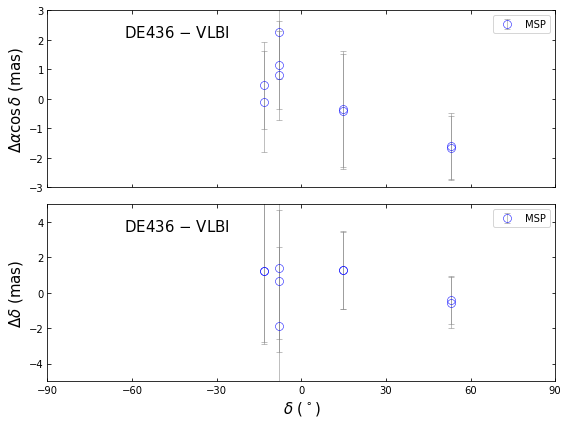

In [46]:
pos_oft_vs_coord(
    vlbi_timing436,
    [-3, 3, -5, 5],
    vlbi_timing436["dra"],
    vlbi_timing436["ddec"],
    add_text=[0.15, 0.85, "DE436 $-$ VLBI"],
    ref="v",
    xaxis="dec",
    divided=True,
)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1  4      0.6      0.3      -2.13       0.27       0.65 J1012+5307    55291      0.2
 2  4      0.5      0.3      -1.78      -0.05       0.63 J1012+5307    55000      0.4
 3  3      0.4      0.2       1.06      -1.47       0.51 J2145-0750    55322      1.2
 4  3      0.3      0.1       0.48      -1.51       0.25 J2145-0750    55657      0.2
 5  3      0.2      0.1       0.19      -1.48       0.06 J2145-0750    55000      0.2


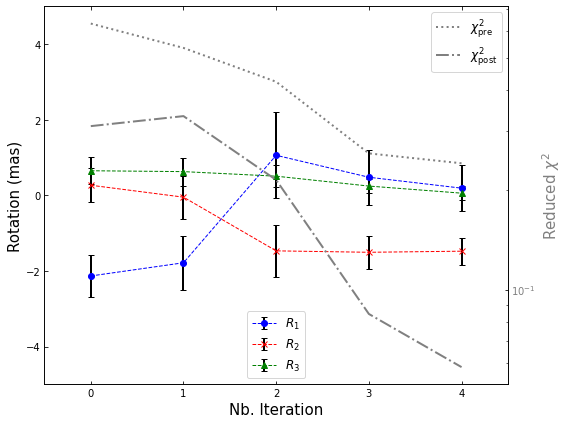

In [47]:
pmt436, sig436, indx, apr_chi2_436, pst_chi2_436 = rot_fit_4_table(
    vlbi_timing436, ref="v")
rot_vs_iter(
    pmt436,
    sig436,
    [-0.5, 4.5, -5, 5],
    apr_chi2=apr_chi2_436,
    pst_chi2=pst_chi2_436,
    ax_loc="lower center",
    ax1_loc="upper right",
)

In [48]:
rot436, iqr436, dra_436, ddec_436, a_chi2_436, p_chi2_436 = simple_rot_fit_4_table(
    vlbi_timing436, ref="v")

[msg] There are 9 timing solutions for 4 pulsars
[msg] Before removing outliers, the reduced chi-squared is 0.52.
[msg] There is no outliers.
[info] NO.Obs  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  R1_err  R2_err R3_err
[info] Unit: mas
[info]  9  4      0.5      0.3      -2.13       0.27       0.65       0.54       0.45       0.36


A short table to summarize the orientation between DE frame and Gaia frame.

In [49]:
mydata = [
    [
        nb_psr_200,
        nb_obs_200,
        rot200[0],
        iqr200[0],
        rot200[1],
        iqr200[1],
        rot200[2],
        iqr200[2],
        a_chi2_200,
        p_chi2_200,
    ],
    #     [
    #         nb_psr_405, nb_obs_405, rot405[0], iqr405[0], rot405[1], iqr405[1],
    #         rot405[2], iqr405[2], a_chi2_405, p_chi2_405
    #     ],
    [
        nb_psr_421,
        nb_obs_421,
        rot421[0],
        iqr421[0],
        rot421[1],
        iqr421[1],
        rot421[2],
        iqr421[2],
        a_chi2_421,
        p_chi2_421,
    ],
    #           [nb_psr_430, nb_obs_430,
    #            rot430[0], iqr430[0], rot430[1], iqr430[1], rot430[2], iqr430[2],
    #            a_chi2_430, p_chi2_430],
    [
        nb_psr_436,
        nb_obs_436,
        rot436[0],
        iqr436[0],
        rot436[1],
        iqr436[1],
        rot436[2],
        iqr436[2],
        a_chi2_436,
        p_chi2_436,
    ],
]

myheaders = [
    "Nb.PSR",
    "Nb.Obs",
    "R1",
    "R1_err",
    "R2",
    "R2_err",
    "R3",
    "R3_err",
    "ApreFitChi2",
    "PostFitChi2",
]
mystubs = [
    "DE200",
    #     "DE405",
    "DE421",
    #            "DE430",
    "DE436"
]

tbl = SimpleTable(
    mydata,
    myheaders,
    mystubs,
    title="Orientation of DE frame wrt. VLBI frame (mas)",
    data_fmts=[
        "%d",
        "%d",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.2f",
        "%6.2f",
    ],
)

print(tbl)

                    Orientation of DE frame wrt. VLBI frame (mas)                    
      Nb.PSR Nb.Obs   R1   R1_err   R2   R2_err   R3   R3_err ApreFitChi2 PostFitChi2
-------------------------------------------------------------------------------------
DE200      4     10   -0.9    2.3  -13.0    2.8  -12.2    1.1       48.00        3.16
DE421      5     14   -0.9    0.5   -0.7    0.5   -0.4    0.3        0.64        0.55
DE436      4      9   -2.1    0.5    0.3    0.5    0.7    0.4        0.52        0.31
-------------------------------------------------------------------------------------
